In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch
from matplotlib import pyplot as plt

In [2]:
# 그래디언트 텐서
x = torch.ones(2, 2, requires_grad=True)    # requires_grad=True는 x에 대한 gradient를 계산하겠다는 의미
y = x + 2
z = 2*y**2
out = z.mean()
print("Result: ", out)

# out 기준 역전파 진행, x의 gradient 계산
out.backward()
print("Gradient of x: ", x.grad)

Result:  tensor(18., grad_fn=<MeanBackward0>)
Gradient of x:  tensor([[3., 3.],
        [3., 3.]])


In [3]:
# 자동 미분 - linear regression 예제
x = torch.FloatTensor(range(5)).unsqueeze(1) # 5x1 크기의 텐서 생성
# x = torch.FloatTensor(range(5)).view(-1, 1)  # 5x1 크기의 텐서 생성
# x = torch.FloatTensor(range(5)).reshape(-1, 1)  # 5x1 크기의 텐서 생성

y = 2 * x + torch.rand(5, 1)
num_features = x.shape[1]       # 인스턴스의 수: 5, 특징의 수: 1

w = torch.randn(num_features, 1, requires_grad=True) # 가중치 텐서 생성
b = torch.randn(1, requires_grad=True)               # 편향 텐서 생성

learning_rate = 1.e-3   # 학습률 설정
optimizer = torch.optim.SGD([w, b], lr=learning_rate) # SGD 옵티마이저 생성

loss_stack = []
for epoch in range(1001):
    optimizer.zero_grad() # 최적화는 계산을 누적시키기 때문에 매 에폭마다 누적된 값을 초기화한다. 즉, 이전 gradient 값들을 초기화한다.
    
    y_pred = torch.matmul(x, w) + b # 예측값 계산
    loss = torch.mean((y_pred - y)**2) # MSE 손실 계산
    loss.backward() # w, b에 대한 loss의 gradient 자동 계산
    
    optimizer.step() # 파라미터 업데이트
    loss_stack.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch:4d}/1000, Loss: {loss.item():.6f}')


# 학습된 모델을 이용해 예측값 계산
with torch.no_grad(): # 최적화를 사용하지 않으므로 requires_grad를 비활성화 한다.
    y_pred = torch.matmul(x, w) + b # with 블록은 새로운 스코프를 생성하지 않기 때문에 with 블록 내부에서 정의된 변수는 외부에서도 접근 가능

Epoch    0/1000, Loss: 66.005783
Epoch  100/1000, Loss: 4.916647
Epoch  200/1000, Loss: 0.763852
Epoch  300/1000, Loss: 0.447015
Epoch  400/1000, Loss: 0.392506
Epoch  500/1000, Loss: 0.359385
Epoch  600/1000, Loss: 0.331019
Epoch  700/1000, Loss: 0.305914
Epoch  800/1000, Loss: 0.283640
Epoch  900/1000, Loss: 0.263873
Epoch 1000/1000, Loss: 0.246331


<Figure size 1000x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Loss graph')

<Axes: >

Text(0.5, 1.0, 'Prediction')

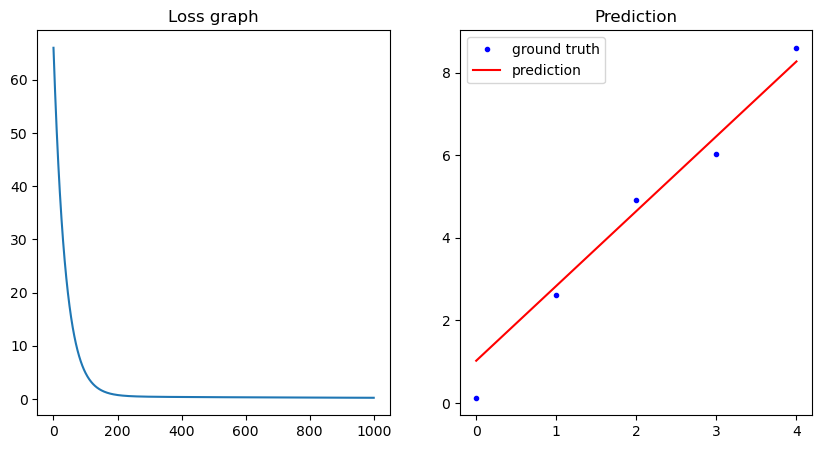

In [4]:
# 시각화 하기
plt.figure(figsize=(10, 5))

# subplot은 하나의 그림(Figure) 안에 여러 개의 작은 그래프(Subplot)를 넣을 때 사용
# 121은 "1행 2열 중 첫 번째 위치"를 의미한다.
plt.subplot(121)
plt.plot(loss_stack)
plt.title('Loss graph')

plt.subplot(122)
plt.plot(x, y, '.b')    # 파란색 점 그래프
plt.plot(x, y_pred, '-r')   # 빨간색 실선 그래프
plt.legend(['ground truth', 'prediction'])
plt.title("Prediction")
plt.show()

`w.grad`는 **`w`라는 텐서 객체 안에 저장된다.**

PyTorch에서 텐서는 그냥 데이터만 들고 있는 게 아니고, **gradient 정보도 함께 저장할 수 있는 구조**이다.

---

### `w.grad`는 `w`의 속성이다

```python
w = torch.randn(3, 1, requires_grad=True)
```

- `requires_grad=True`를 설정하면 PyTorch는 `w`가 **학습 대상**임을 인식하고,
- 나중에 `loss.backward()`를 호출하면,
- PyTorch가 자동으로 **`w.grad`에 기울기를 저장**한다.

---

### 연결 포인트

loss.backward()
→ .grad 값 계산됨 (ex. w.grad, b.grad에 저장)

optimizer.step()
→ .grad 값 이용해서 w, b 자체를 업데이트

---

### loss.backward( )의 작동 방식 

> PyTorch의 기본 `loss.backward()`는 gradient의 평균이 아니라, 합(sum)을 계산한다.  
> 그래서 `optimizer.step()`은 "gradient의 합 × learning rate"로 파라미터를 업데이트하게 된다.

---

### 그럼 왜 이런 구조일까?

PyTorch는 `loss.backward()` 호출 시에:

```python
dL/dw = ∂L₁/∂w + ∂L₂/∂w + ∂L₃/∂w + ... + ∂L₅/∂w  # → 합!
```

을 그대로 `.grad`에 넣어준다.

그래서 만약 우리가 5개 샘플(batch size 5)을 한꺼번에 학습했다면,  
loss 함수가 각 샘플의 손실을 평균한 거라면, gradient도 평균을 내줘야 **스케일이 잘 맞는다.**

---

### 그래서 대부분의 경우 이렇게 처리!

```python
loss = torch.mean((y_pred - y) ** 2)  # 평균 손실
loss.backward()
```

- torch.mean은 각 ∇Lᵢ를 모두 구한 뒤 내부에서 torch.sum을 호출해 더하고, 마지막에 크기로 나누어 평균을 구한다.